# 🎓 Life Expectancy Prediction – Full Pipeline with Stacking Ensemble

In [1]:
!pip install -q catboost tab-transformer-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor
from tab_transformer_pytorch import TabTransformer


In [3]:
# Load data
df = pd.read_csv("modified.csv")

# Column setup
target = 'Life expectancy'
categorical_cols = ['Gender']
ignore_cols = ['Country', 'Year', 'Year.1', target]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ignore_cols]

# Encode categorical
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# Scale numericals
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split
X = df[categorical_cols + numerical_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [4]:
# Split into categorical and continuous
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_categ_train = torch.tensor(X_train.iloc[:, 0].values, dtype=torch.long).unsqueeze(1).to(device)
X_cont_train = torch.tensor(X_train.iloc[:, 1:].values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_categ_test = torch.tensor(X_test.iloc[:, 0].values, dtype=torch.long).unsqueeze(1).to(device)
X_cont_test = torch.tensor(X_test.iloc[:, 1:].values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Model
model = TabTransformer(
    categories=(2,),
    num_continuous=X_train.shape[1] - 1,
    dim=64,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1
).to(device)

from torch.utils.data import DataLoader, TensorDataset
from torch import nn

train_dataset = TensorDataset(X_categ_train, X_cont_train, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train TabTransformer
model.train()
for epoch in range(10):
    total_loss = 0
    for x_cat, x_cont, yb in train_loader:
        optimizer.zero_grad()
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 26.5336
Epoch 2: Loss = 8.4288
Epoch 3: Loss = 7.5323
Epoch 4: Loss = 6.2093
Epoch 5: Loss = 5.8302
Epoch 6: Loss = 5.4447
Epoch 7: Loss = 4.8590
Epoch 8: Loss = 4.5968
Epoch 9: Loss = 4.1327
Epoch 10: Loss = 3.8597


In [5]:
# ElasticNet
elastic_model = ElasticNet()
elastic_model.fit(X_train, y_train)
joblib.dump(elastic_model, "elastic_model.pkl")

# CatBoost
catboost_model = CatBoostRegressor(verbose=0)
catboost_model.fit(X_train, y_train)
catboost_model.save_model("catboost_model.cbm")


In [17]:
class TorchTabTransformerWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device

    def fit(self, X, y):
        # Already trained externally — no action needed
        return self

    def predict(self, X):
        # Expecting X to be a DataFrame with categorical in col 0, rest numeric
        x_categ = torch.tensor(X.iloc[:, 0].values, dtype=torch.long).unsqueeze(1).to(self.device)
        x_cont = torch.tensor(X.iloc[:, 1:].values, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont)
        return preds.cpu().numpy().flatten()


In [18]:
# Manual Ensemble Logic

# predictions from all base models
cat_preds = catboost_model.predict(X_test)
elastic_preds = elastic_model.predict(X_test)
tab_preds = TorchTabTransformerWrapper(model, device=device).predict(X_test)

# Stack predictions as features for meta-model
import numpy as np
meta_X = np.vstack([cat_preds, elastic_preds, tab_preds]).T
meta_y = y_test

# Train meta-model
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)

# Final ensemble prediction
stack_preds = meta_model.predict(meta_X)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(meta_y, stack_preds)
rmse = np.sqrt(mean_squared_error(meta_y, stack_preds))
r2 = r2_score(meta_y, stack_preds)

print(f"\n📊 Manual Stacked Ensemble Results:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")



📊 Manual Stacked Ensemble Results:
MAE:  0.0512
RMSE: 0.0717
R²:   0.9947


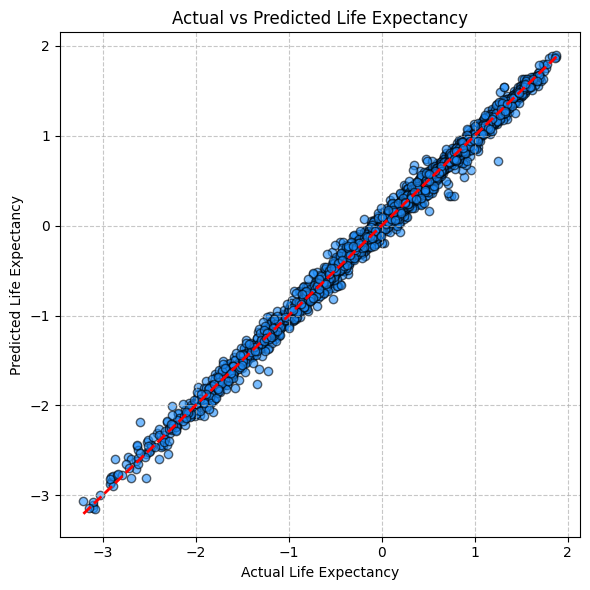

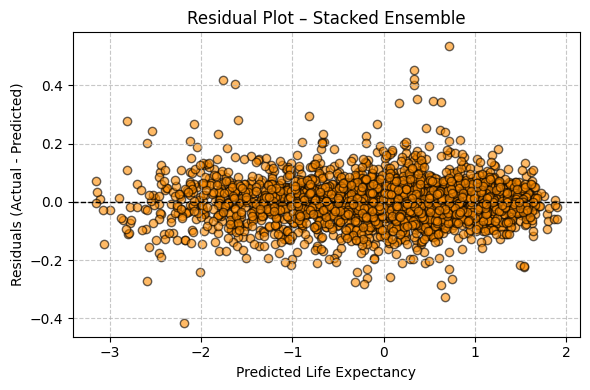

In [21]:
import matplotlib.pyplot as plt

# Fix: use y_test and stack_preds directly
actual = y_test
predicted = stack_preds

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(actual, predicted, alpha=0.6, color='dodgerblue', edgecolors='k')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=2)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("actual_vs_predicted_plot.png")
plt.show()

# Residual Plot
residuals = actual - predicted
plt.figure(figsize=(6, 4))
plt.scatter(predicted, residuals, alpha=0.6, color='darkorange', edgecolors='k')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot – Stacked Ensemble')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("residual_plot.png")
plt.show()
